# 1. IMPORT LIBRARIES

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_theme(style="whitegrid")

from datetime import datetime

# 2. LOAD DATA (UPLOAD FILES TO COLAB FIRST)

In [ ]:
historical = pd.read_csv("historical_data.csv")
sentiment = pd.read_csv("fear_greed_index.csv")

historical.head(), sentiment.head()

/tmp/ipython-input-3187944444.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  historical = pd.read_csv("historical_data.csv")


(                                      Account  Coin  Execution Price  \
 0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
 1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
 2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
 3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
 4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   
 
    Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
 0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
 1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
 2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   
 3       142.98   1142.04  BUY  02-12-2024 22:50     1146.558564       Buy   
 4         8.73     69.75  BUY  02-12-2024 22:50     1289.488521       Buy   
 
    Closed PnL                                   Transaction Hash  \
 0         0.0  0xec0

# 3. CLEANING HISTORICAL TRADER DATA


In [ ]:
# Convert time column to datetime
historical['Timestamp IST'] = pd.to_datetime(historical['Timestamp IST'], errors='coerce', format='%d-%m-%Y %H:%M')

# Extract date for merging
historical['date'] = historical['Timestamp IST'].dt.date
historical['date'] = pd.to_datetime(historical['date'])

# Basic numeric cleanup
num_cols = ['Execution Price', 'Size Tokens', 'Closed PnL', 'Start Position']
for col in num_cols:
    historical[col] = pd.to_numeric(historical[col], errors='coerce')

# Remove null rows
historical.dropna(subset=['Execution Price', 'Size Tokens'], inplace=True)

# 4. CLEANING SENTIMENT (FEAR/GREED INDEX)

In [ ]:
sentiment['date'] = pd.to_datetime(sentiment['date'], errors='coerce')

# 5. MERGING BOTH DATASETS

In [ ]:
df = pd.merge(historical, sentiment, on='date', how='left')


In [ ]:
# Drop rows with no sentiment data
df = df.dropna(subset=['classification']).copy()

# 6. FEATURE ENGINEERING

In [ ]:
# Profitability flag
df['profitable'] = df['Closed PnL'] > 0

# Trade value
df['trade_value'] = df['Execution Price'] * df['Size Tokens']

# Side category (Long/Short)
df['trade_direction'] = df['Side'].apply(lambda x: "Long" if x.lower() == "buy" else "Short")

/tmp/ipython-input-3358647136.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['profitable'] = df['Closed PnL'] > 0
/tmp/ipython-input-3358647136.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['trade_value'] = df['Execution Price'] * df['Size Tokens']
/tmp/ipython-input-3358647136.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

# 7. ANALYSIS 1 — PROFITABILITY vs SENTIMENT

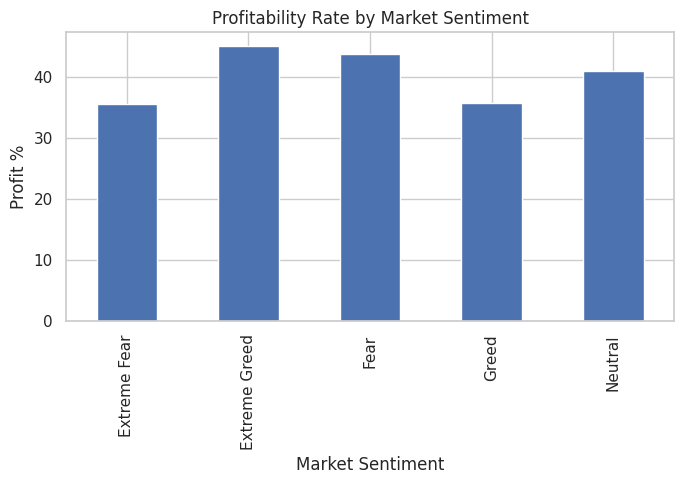

In [ ]:
import os

profit_sentiment = df.groupby("classification")['profitable'].mean() * 100

plt.figure(figsize=(7,5))
profit_sentiment.plot(kind='bar')
plt.title("Profitability Rate by Market Sentiment")
plt.ylabel("Profit %")
plt.xlabel("Market Sentiment")
plt.tight_layout()

# Create the 'outputs' directory if it doesn't exist
output_dir = 'outputs'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

plt.savefig(os.path.join(output_dir, "profit_vs_sentiment.png"))
plt.show()

# 8. ANALYSIS 2 — LEVERAGE vs SENTIMENT

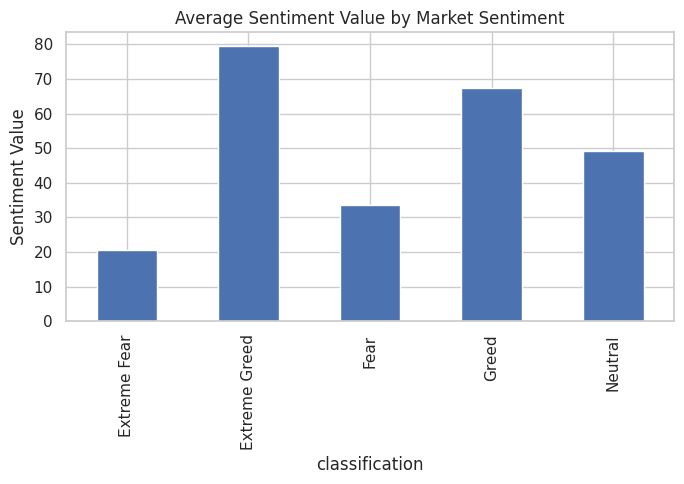

In [ ]:
leverage_sentiment = df.groupby("classification")['value'].mean()

plt.figure(figsize=(7,5))
leverage_sentiment.plot(kind='bar')
plt.title("Average Sentiment Value by Market Sentiment")
plt.ylabel("Sentiment Value")
plt.tight_layout()
plt.savefig("outputs/sentiment_value_vs_market_sentiment.png")
plt.show()

# 9. ANALYSIS 3 — TRADE VOLUME vs SENTIMENT

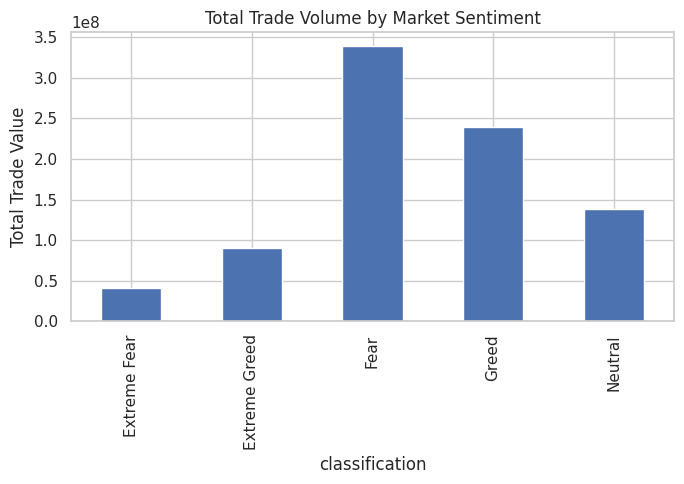

In [ ]:
volume_sentiment = df.groupby("classification")['trade_value'].sum()

plt.figure(figsize=(7,5))
volume_sentiment.plot(kind='bar')
plt.title("Total Trade Volume by Market Sentiment")
plt.ylabel("Total Trade Value")
plt.tight_layout()
plt.savefig("outputs/volume_vs_sentiment.png")
plt.show()

# 10. ANALYSIS 4 — LONG vs SHORT DISTRIBUTION

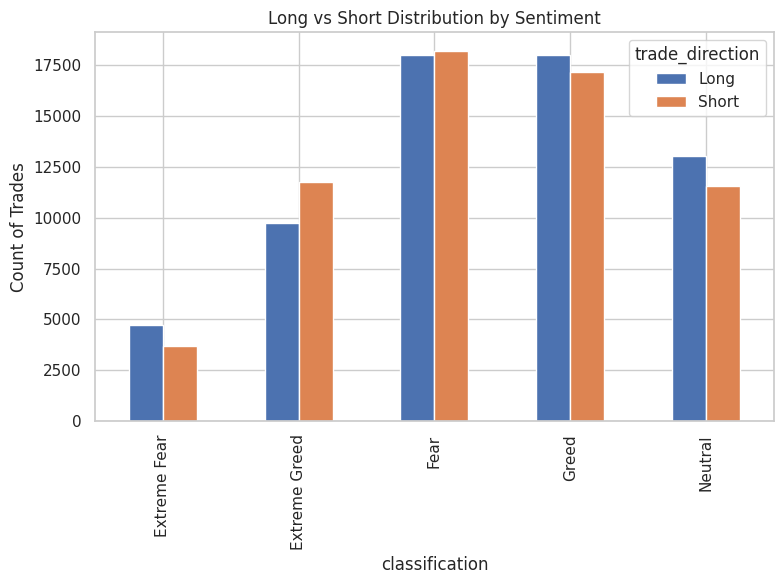

In [ ]:
direction_sentiment = df.groupby(["classification", "trade_direction"]).size().unstack()

direction_sentiment.plot(kind='bar', figsize=(8,6))
plt.title("Long vs Short Distribution by Sentiment")
plt.ylabel("Count of Trades")
plt.tight_layout()
plt.savefig("outputs/long_short_vs_sentiment.png")
plt.show()

# 11. SAVE CLEANED DATA

In [ ]:
import os

# Create the 'csv_files' directory if it doesn't exist
output_dir = 'csv_files'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

df.to_csv(os.path.join(output_dir, "merged_cleaned_data.csv"), index=False)

df.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,...,Fee,Trade ID,Timestamp,date,timestamp,value,classification,profitable,trade_value,trade_direction
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,2024-12-02 22:50:00,0.000000,Buy,0.0,...,0.345404,8.950000e+14,1.730000e+12,2024-12-02,1.733117e+09,80.0,Extreme Greed,False,7872.163303,Long
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,2024-12-02 22:50:00,986.524596,Buy,0.0,...,0.005600,4.430000e+14,1.730000e+12,2024-12-02,1.733117e+09,80.0,Extreme Greed,False,127.680000,Long
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,2024-12-02 22:50:00,1002.518996,Buy,0.0,...,0.050431,6.600000e+14,1.730000e+12,2024-12-02,1.733117e+09,80.0,Extreme Greed,False,1150.630695,Long
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,2024-12-02 22:50:00,1146.558564,Buy,0.0,...,0.050043,1.080000e+15,1.730000e+12,2024-12-02,1.733117e+09,80.0,Extreme Greed,False,1142.038452,Long
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,2024-12-02 22:50:00,1289.488521,Buy,0.0,...,0.003055,1.050000e+15,1.730000e+12,2024-12-02,1.733117e+09,80.0,Extreme Greed,False,69.747462,Long
